# IN PROGRESS!!!

# Dense Neuronal Network Model for PTB data 
As we concluded before, for PTB data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: Standard Scaler

If you don't have the original files: run the notebook `preprocessing_ptb_standard_oversampling.ipynb`     
**Input** : the original data.   
ptbdb_normal.csv  
ptbdb_abnormal.csv  

Output: DNN model trained  
model_dnn_ptb.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'ptb_train_standard_oversampling.csv', 
    'test': data_path + 'ptb_test_standard_oversamling.csv'  
})

OutputFiles = dict({
    'model': model_output_path +  'model_dnn_ptb.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



# Dense Neuronal Network with Standard Scaler

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# define model
model = Sequential() # Sequential model is used to add layers one by one to the model, in a linear manner

# Input Layer
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1])) # relu, because we want to avoid negative values
# input_dim is the number of features in the dataset: 187

# Hidden Layers: 3 hidden layers with 64, 128, and 32 neurons respectively
model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization()) # BatchNormalization is used to normalize the activations of the previous layer at each batch
model.add(Dropout(0.3)) # Dropout is used to prevent overfitting. 0.3 means 30% of the neurons will be turned off randomly

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid')) # 1 means 1 neuron in the output layer, sigmoid, because we want to predict probabilities

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adam is a popular optimizer, binary_crossentropy is used for binary classification

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs with no improvement after which training will be stopped
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001) # the factor by which the learning rate will be reduced, min_lr is the lower bound for the learning rate

# Callbacks for plotting
train_loss = [] # to store training loss
val_loss = []
train_accuracy = []
val_accuracy = []


epochs = 1000 # number of epochs for training, 1000 is a large number, but early stopping will stop the training when the model stops improving
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=10, validation_data=(X_test, y_test), 
                        verbose=0, callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to the respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress at each 10th epoch for feedback
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/1000 - Loss: 0.2090, Val Loss: 0.1313, Accuracy: 0.9275, Val Accuracy: 0.9546
Epoch 20/1000 - Loss: 0.1614, Val Loss: 0.0969, Accuracy: 0.9471, Val Accuracy: 0.9684
Epoch 30/1000 - Loss: 0.1171, Val Loss: 0.0955, Accuracy: 0.9660, Val Accuracy: 0.9703
Epoch 40/1000 - Loss: 0.1036, Val Loss: 0.0864, Accuracy: 0.9686, Val Accuracy: 0.9726
Epoch 50/1000 - Loss: 0.1073, Val Loss: 0.0736, Accuracy: 0.9694, Val Accuracy: 0.9750
Epoch 60/1000 - Loss: 0.0896, Val Loss: 0.1095, Accuracy: 0.9764, Val Accuracy: 0.9641
Epoch 70/1000 - Loss: 0.0826, Val Loss: 0.0778, Accuracy: 0.9761, Val Accuracy: 0.9731
Epoch 80/1000 - Loss: 0.0796, Val Loss: 0.0968, Accuracy: 0.9775, Val Accuracy: 0.9826
Epoch 90/1000 - Loss: 0.0792, Val Loss: 0.0848, Accuracy: 0.9778, Val Accuracy: 0.9705
Epoch 100/1000 - Loss: 0.0684, Val Loss: 0.0573, Accuracy: 0.9798, Val Accuracy: 0.9831
Epoch 110/1000 - Loss: 0.1074, Val Loss: 0.0644, Accuracy: 0.9654, Val Accuracy: 0.9817
Epoch 120/1000 - Loss: 0.0542, Val Loss: 

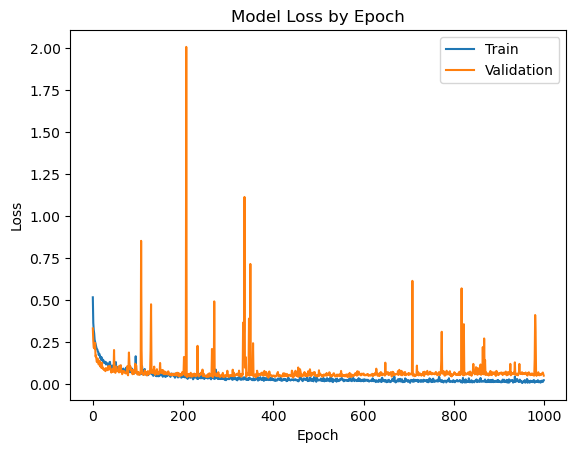

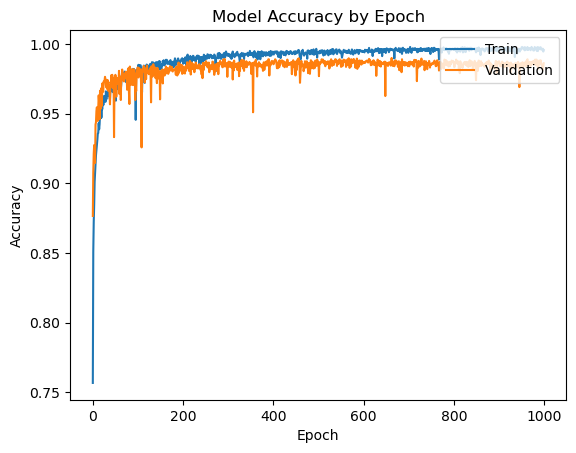

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
[[2079    8]
 [  50 2066]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2087
           1       1.00      0.98      0.99      2116

    accuracy                           0.99      4203
   macro avg       0.99      0.99      0.99      4203
weighted avg       0.99      0.99      0.99      4203

F1 Score: 0.9861575178997614


In [6]:
# Plotting the Loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")

# Save DNN Model

In [7]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(model, model_file)